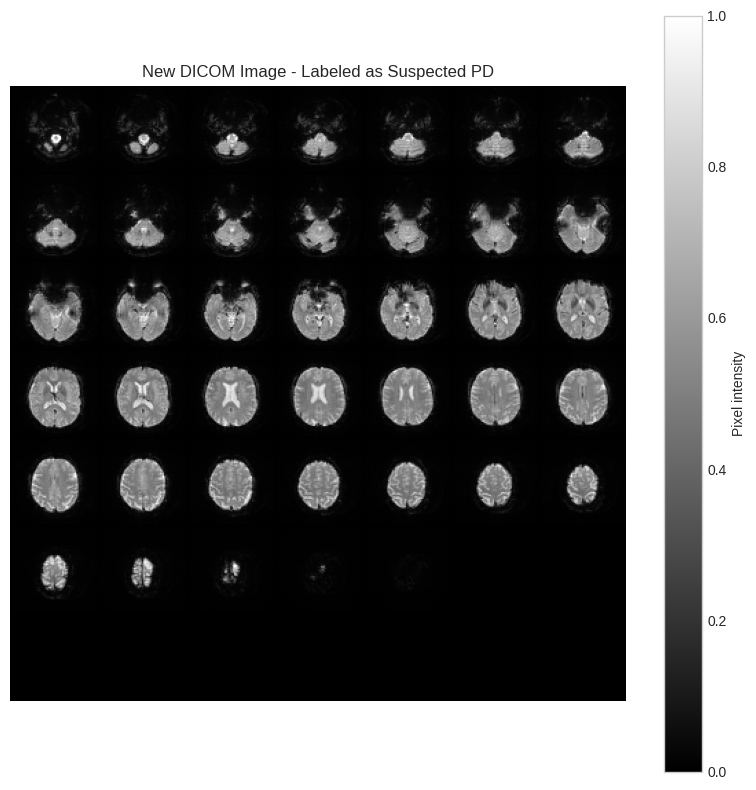


Feature summary of new image:
img_mean: 0.0954
img_std: 0.1962
img_min: 0.0000
img_max: 1.0000
img_median: 0.0097
img_kurtosis: 6.1058
img_skewness: 2.1332
img_entropy: 6.2347
img_contrast: 513.4880
img_dissimilarity: 7.7335
img_homogeneity: 0.5860
img_energy: 0.2680
img_correlation: 0.8978
img_ASM: 0.0719
Enhanced visualizations have been saved.


In [ ]:
import os
import pydicom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from PIL import Image
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import shannon_entropy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


# Fix the indentation in the original code
def explore_dicom_data(dicom_dir):
    dicom_files = [f for f in os.listdir(dicom_dir) if f.endswith('.dcm')]
    print(f"Found {len(dicom_files)} DICOM files")
    
    sample_file = os.path.join(dicom_dir, dicom_files[0])
    dicom_data = pydicom.dcmread(sample_file)
    
    print(f"Patient ID: {dicom_data.PatientID if 'PatientID' in dicom_data else 'N/A'}")
    print(f"Modality: {dicom_data.Modality if 'Modality' in dicom_data else 'N/A'}")
    print(f"Image shape: {dicom_data.pixel_array.shape}")
    
    return dicom_data

def explore_image_data(image_dir):
    categories = os.listdir(image_dir)
    for category in categories:
        category_path = os.path.join(image_dir, category)
        if os.path.isdir(category_path):
            image_files = [f for f in os.listdir(category_path) if f.endswith(('.png', '.jpg'))]
            print(f"Category '{category}': {len(image_files)} images")
            
            # Sample image
            if image_files:
                sample_img = Image.open(os.path.join(category_path, image_files[0]))
                print(f"Sample image shape: {np.array(sample_img).shape}")

def preprocess_dicom(dicom_path):
    """Convert DICOM to normalized numpy array"""
    dicom = pydicom.dcmread(dicom_path)
    img_array = dicom.pixel_array
    
    # Apply windowing for better contrast if needed
    if hasattr(dicom, 'WindowCenter') and hasattr(dicom, 'WindowWidth'):
        try:
            center = dicom.WindowCenter
            width = dicom.WindowWidth
            if isinstance(center, list):
                center = center[0]
            if isinstance(width, list):
                width = width[0]
                
            img_min = center - width // 2
            img_max = center + width // 2
            img_array = np.clip(img_array, img_min, img_max)
        except:
            pass
    
    # Normalize to 0-1
    if img_array.max() > 0:
        img_array = (img_array - img_array.min()) / (img_array.max() - img_array.min())
    
    return img_array

def extract_image_features(image, name=''):
    """Extract statistical and textural features from an image"""
    features = {}
    
    # Basic statistical features
    features[f'{name}_mean'] = np.mean(image)
    features[f'{name}_std'] = np.std(image)
    features[f'{name}_min'] = np.min(image)
    features[f'{name}_max'] = np.max(image)
    features[f'{name}_median'] = np.median(image)
    features[f'{name}_kurtosis'] = ((image - np.mean(image))**4).mean() / ((image - np.mean(image))**2).mean()**2
    features[f'{name}_skewness'] = ((image - np.mean(image))**3).mean() / ((image - np.mean(image))**2).mean()**1.5
    
    # Entropy
    features[f'{name}_entropy'] = shannon_entropy(image)
    
    # Convert to uint8 for GLCM calculations
    img_uint8 = (image * 255).astype(np.uint8)
    
    # Extract texture features if enough unique values
    if len(np.unique(img_uint8)) > 5:
        try:
            glcm = graycomatrix(img_uint8, distances=[1, 3], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], 
                               levels=256, symmetric=True, normed=True)
            
            # Get average over distances and angles for more robust features
            features[f'{name}_contrast'] = np.mean(graycoprops(glcm, 'contrast'))
            features[f'{name}_dissimilarity'] = np.mean(graycoprops(glcm, 'dissimilarity'))
            features[f'{name}_homogeneity'] = np.mean(graycoprops(glcm, 'homogeneity'))
            features[f'{name}_energy'] = np.mean(graycoprops(glcm, 'energy'))
            features[f'{name}_correlation'] = np.mean(graycoprops(glcm, 'correlation'))
            features[f'{name}_ASM'] = np.mean(graycoprops(glcm, 'ASM'))
        except Exception as e:
            print(f"Error calculating GLCM features: {e}")
            features[f'{name}_contrast'] = np.nan
            features[f'{name}_dissimilarity'] = np.nan
            features[f'{name}_homogeneity'] = np.nan
            features[f'{name}_energy'] = np.nan
            features[f'{name}_correlation'] = np.nan
            features[f'{name}_ASM'] = np.nan
    
    return features

def display_image(image, title=""):
    """Display an image with a title"""
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.colorbar(label='Pixel intensity')
    plt.tight_layout()
    plt.show()

def process_new_dicom(new_dicom_path, features_csv='image_features.csv', new_label='Unknown'):
    """Process a new DICOM file and visualize it alongside existing data"""
    # Load existing features
    if not os.path.exists(features_csv):
        print(f"Error: {features_csv} not found. Please run the feature extraction first.")
        return
    
    df = pd.read_csv(features_csv)
    
    # Process the new DICOM image
    try:
        new_image = preprocess_dicom(new_dicom_path)
        
        # Display the new image
        display_image(new_image, f"New DICOM Image - Labeled as {new_label}")
        
        # Extract features from the new image
        new_features = extract_image_features(new_image, 'img')
        new_features['group'] = 'New_Sample'
        new_features['label'] = new_label
        new_features['image_id'] = 'new_scan'
        
        # Create a dataframe with the new features
        new_df = pd.DataFrame([new_features])
        
        # Print feature summary of the new image
        print("\nFeature summary of new image:")
        for key, value in new_features.items():
            if key.startswith('img_'):
                print(f"{key}: {value:.4f}")
        
        # Combine with existing features
        global combined_df
        combined_df = pd.concat([df, new_df])
        
        # Save the new image
        output_dir = "brain_images_with_labels"
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        Image.fromarray((new_image * 255).astype(np.uint8)).save(
            os.path.join(output_dir, f'new_dicom_sample_{new_label.lower()}.png'))
        
        # Create visualizations with the new data point
        create_enhanced_visualizations(combined_df)
        
    except Exception as e:
        print(f"Error processing the new DICOM file: {e}")
        import traceback
        traceback.print_exc()

def create_enhanced_visualizations(combined_df):
    """Create enhanced visualizations with the new data point highlighted"""
    # Set up a better style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Define a better color palette
    colors = {
        'HC': '#1f77b4',       # Blue
        'PD': '#ff7f0e',       # Orange
        'New_Sample': '#2ca02c' # Green
    }
    
    # Key features to visualize
    features = ['img_mean', 'img_std', 'img_entropy', 'img_contrast', 'img_homogeneity']
    
    # 1. Feature comparison with violin plots
    plt.figure(figsize=(16, 12))
    
    for i, feature in enumerate(features):
        plt.subplot(2, 3, i+1)
        
        # Violin plots for HC and PD
        sns.violinplot(x='group', y=feature, data=combined_df[combined_df['group'] != 'New_Sample'], 
                      palette={'HC': colors['HC'], 'PD': colors['PD']}, inner='quartile')
        
        # Mark the new sample as a star
        new_sample = combined_df[combined_df['group'] == 'New_Sample']
        if not new_sample.empty:
            for j, row in new_sample.iterrows():
                plt.scatter(2, row[feature], 
                           color=colors['New_Sample'], marker='*', s=300, zorder=10, 
                           edgecolor='black', linewidth=1.5)
                plt.text(2, row[feature], f"  New ({row.get('label', 'Unknown')})", 
                        fontsize=10, va='center')
        
        plt.title(f'{feature} Distribution by Group', fontsize=12, fontweight='bold')
        plt.xticks([0, 1, 2], ['Healthy', 'Parkinson\'s', 'New Sample'])
        
        # Add reference lines for the new sample value
        if not new_sample.empty:
            for j, row in new_sample.iterrows():
                plt.axhline(y=row[feature], color=colors['New_Sample'], linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig('feature_violin_plots.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 2. Feature comparison with swarm plots
    plt.figure(figsize=(16, 12))
    
    for i, feature in enumerate(features):
        plt.subplot(2, 3, i+1)
        
        # Box plot for HC and PD with individual points
        sns.boxplot(x='group', y=feature, data=combined_df[combined_df['group'] != 'New_Sample'], 
                   palette={'HC': colors['HC'], 'PD': colors['PD']}, width=0.5, fliersize=0)
        
        sns.swarmplot(x='group', y=feature, data=combined_df[combined_df['group'] != 'New_Sample'], 
                     palette={'HC': colors['HC'], 'PD': colors['PD']}, 
                     alpha=0.7, size=4, edgecolor='black', linewidth=0.5)
        
        # Mark the new sample as a star
        new_sample = combined_df[combined_df['group'] == 'New_Sample']
        if not new_sample.empty:
            for j, row in new_sample.iterrows():
                plt.scatter(2, row[feature], 
                           color=colors['New_Sample'], marker='*', s=300, zorder=10, 
                           edgecolor='black', linewidth=1.5)
                plt.text(2, row[feature], f"  New ({row.get('label', 'Unknown')})", 
                        fontsize=10, va='center')
        
        plt.title(f'{feature} Distribution by Group', fontsize=12, fontweight='bold')
        plt.xticks([0, 1, 2], ['Healthy', 'Parkinson\'s', 'New Sample'])
    
    plt.tight_layout()
    plt.savefig('feature_swarm_plots.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 3. Combined PCA and t-SNE visualization
    feature_cols = [col for col in combined_df.columns if col.startswith('img_')]
    X = combined_df[feature_cols].fillna(0)
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Calculate PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X_scaled)
    
    # Calculate t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X)-1))
    tsne_result = tsne.fit_transform(X_scaled)
    
    # Create DataFrames
    pca_df = pd.DataFrame({
        'PC1': pca_result[:, 0],
        'PC2': pca_result[:, 1],
        'group': combined_df['group']
    })
    
    tsne_df = pd.DataFrame({
        'TSNE1': tsne_result[:, 0],
        'TSNE2': tsne_result[:, 1],
        'group': combined_df['group']
    })
    
    # Explained variance for PCA
    explained_variance = pca.explained_variance_ratio_ * 100
    
    # Create a single figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # PCA Plot
    for group, color in colors.items():
        mask = pca_df['group'] == group
        if group == 'New_Sample':
            for i, idx in enumerate(pca_df.index[mask]):
                new_label = combined_df.loc[idx].get('label', 'Unknown')
                axes[0].scatter(pca_df.loc[idx, 'PC1'], pca_df.loc[idx, 'PC2'], 
                             c=color, marker='*', s=300, edgecolor='black', linewidth=1.5,
                             label=f'New Sample ({new_label})')
        else:
            axes[0].scatter(pca_df.loc[mask, 'PC1'], pca_df.loc[mask, 'PC2'], 
                        c=color, label=group, alpha=0.7, s=70, edgecolor='black', linewidth=0.5)
    
    axes[0].set_title(f'PCA of Brain Image Features\nExplained Variance: PC1 {explained_variance[0]:.1f}%, PC2 {explained_variance[1]:.1f}%', 
                   fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Principal Component 1', fontsize=10)
    axes[0].set_ylabel('Principal Component 2', fontsize=10)
    axes[0].grid(True, linestyle='--', alpha=0.7)
    
    # t-SNE Plot
    for group, color in colors.items():
        mask = tsne_df['group'] == group
        if group == 'New_Sample':
            for i, idx in enumerate(tsne_df.index[mask]):
                new_label = combined_df.loc[idx].get('label', 'Unknown')
                axes[1].scatter(tsne_df.loc[idx, 'TSNE1'], tsne_df.loc[idx, 'TSNE2'], 
                             c=color, marker='*', s=300, edgecolor='black', linewidth=1.5,
                             label=f'New Sample ({new_label})')
        else:
            axes[1].scatter(tsne_df.loc[mask, 'TSNE1'], tsne_df.loc[mask, 'TSNE2'], 
                        c=color, label=group, alpha=0.7, s=70, edgecolor='black', linewidth=0.5)
    
    axes[1].set_title('t-SNE of Brain Image Features', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('t-SNE Dimension 1', fontsize=10)
    axes[1].set_ylabel('t-SNE Dimension 2', fontsize=10)
    axes[1].grid(True, linestyle='--', alpha=0.7)
    
    # Add legends to both plots
    for ax in axes:
        ax.legend(loc='best', frameon=True, framealpha=0.9)
    
    plt.tight_layout()
    plt.savefig('dimensionality_reduction_plots.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 4. Radar chart of features
    selected_features = ['img_mean', 'img_std', 'img_entropy', 'img_contrast', 'img_homogeneity']
    
    # Function to create a radar chart
    def create_radar_chart(df, features, groups, colors, title):
        # Compute means for each group
        group_means = {}
        
        # Calculate means for HC and PD groups
        for group in groups:
            group_df = df[df['group'] == group]
            if len(group_df) > 0:
                group_means[group] = [group_df[feature].mean() for feature in features]
        
        # Get values for the new sample if it exists
        new_samples = df[df['group'] == 'New_Sample']
        if len(new_samples) > 0:
            for i, new_sample in new_samples.iterrows():
                new_sample_label = new_sample.get('label', 'Unknown')
                group_means[f'New Sample ({new_sample_label})'] = [new_sample[feature] for feature in features]
        
        # Min-max scaling for better visualization
        min_values = df[features].min()
        max_values = df[features].max()
        
        for group in group_means:
            for i, feature in enumerate(features):
                val = group_means[group][i]
                min_val = min_values[feature]
                max_val = max_values[feature]
                # Scale to 0-1
                if max_val > min_val:
                    group_means[group][i] = (val - min_val) / (max_val - min_val)
                else:
                    group_means[group][i] = 0.5
        
        # Create the radar chart
        angles = np.linspace(0, 2*np.pi, len(features), endpoint=False).tolist()
        angles += angles[:1]  # Close the loop
        
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
        
        for group in group_means:
            values = group_means[group]
            values += values[:1]  # Close the loop
            
            if 'New Sample' in group:
                ax.plot(angles, values, 'o-', linewidth=2, label=group, color=colors['New_Sample'])
                ax.fill(angles, values, color=colors['New_Sample'], alpha=0.25)
            else:
                ax.plot(angles, values, 'o-', linewidth=2, label=group, color=colors[group])
                ax.fill(angles, values, color=colors[group], alpha=0.25)
        
        # Set labels
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels([f.replace('img_', '') for f in features], fontsize=12)
        
        # Customize the chart
        ax.set_title(title, fontsize=15, fontweight='bold', pad=20)
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Add legend
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
        
        return fig
    
    # Create and save the radar chart
    radar_fig = create_radar_chart(
        combined_df, 
        selected_features, 
        ['HC', 'PD'], 
        colors, 
        'Feature Comparison - Radar Chart'
    )
    
    radar_fig.savefig('radar_chart_comparison.png', dpi=300, bbox_inches='tight')
    plt.close(radar_fig)
    
    # 5. Feature importance visualization
    # Calculate feature importance for distinguishing HC vs PD
    from sklearn.ensemble import RandomForestClassifier
    
    # Filter out rows with missing values
    X_filtered = combined_df[combined_df['group'] != 'New_Sample'][feature_cols].fillna(0)
    y_filtered = (combined_df[combined_df['group'] != 'New_Sample']['group'] == 'PD').astype(int)
    
    if len(X_filtered) > 5:  # Only run if we have enough samples
        # Train a simple random forest to get feature importance
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_filtered, y_filtered)
        
        # Get feature importance
        importances = clf.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        # Plot the feature importance
        plt.figure(figsize=(12, 8))
        plt.title('Feature Importance for HC vs PD Classification', fontsize=15, fontweight='bold')
        plt.bar(range(X_filtered.shape[1]), importances[indices], align='center')
        plt.xticks(range(X_filtered.shape[1]), [X_filtered.columns[i].replace('img_', '') for i in indices], rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    print("Enhanced visualizations have been saved.")

# Example usage:
# Replace with the path to your new DICOM file
process_new_dicom('/home/antriksh/Desktop/DAV PROJECT/DCM_Images-20231213T092329Z-001/DCM_Images/PPMI_103542_MR_rsfMRI_LR__br_raw_20220106125148939_10_S1093544_I1530517.dcm', new_label='Suspected PD')

In [ ]:
def create_enhanced_visualizations(combined_df):
    """Create enhanced visualizations with the new data point highlighted"""
    # Set up a better style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Define a better color palette
    colors = {
        'HC': '#1f77b4',       # Blue
        'PD': '#ff7f0e',       # Orange
        'New_Sample': '#2ca02c' # Green
    }
    
    # Key features to visualize
    features = ['img_mean', 'img_std', 'img_entropy', 'img_contrast', 'img_homogeneity']
    
    # 1. Feature comparison with violin plots
    plt.figure(figsize=(16, 12))
    
    for i, feature in enumerate(features):
        plt.subplot(2, 3, i+1)
        
        # Violin plots for HC and PD
        sns.violinplot(x='group', y=feature, data=combined_df[combined_df['group'] != 'New_Sample'], 
                      palette={'HC': colors['HC'], 'PD': colors['PD']}, inner='quartile')
        
        # Mark the new sample as a star
        new_sample = combined_df[combined_df['group'] == 'New_Sample']
        if not new_sample.empty:
            for j, row in new_sample.iterrows():
                plt.scatter(2, row[feature], 
                           color=colors['New_Sample'], marker='*', s=300, zorder=10, 
                           edgecolor='black', linewidth=1.5)
                plt.text(2, row[feature], f"  New ({row.get('label', 'Unknown')})", 
                        fontsize=10, va='center')
        
        plt.title(f'{feature} Distribution by Group', fontsize=12, fontweight='bold')
        plt.xticks([0, 1, 2], ['Healthy', 'Parkinson\'s', 'New Sample'])
        
        # Add reference lines for the new sample value
        if not new_sample.empty:
            for j, row in new_sample.iterrows():
                plt.axhline(y=row[feature], color=colors['New_Sample'], linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig('feature_violin_plots.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 2. Feature comparison with swarm plots
    plt.figure(figsize=(16, 12))
    
    for i, feature in enumerate(features):
        plt.subplot(2, 3, i+1)
        
        # Box plot for HC and PD with individual points
        sns.boxplot(x='group', y=feature, data=combined_df[combined_df['group'] != 'New_Sample'], 
                   palette={'HC': colors['HC'], 'PD': colors['PD']}, width=0.5, fliersize=0)
        
        sns.swarmplot(x='group', y=feature, data=combined_df[combined_df['group'] != 'New_Sample'], 
                     palette={'HC': colors['HC'], 'PD': colors['PD']}, 
                     alpha=0.7, size=4, edgecolor='black', linewidth=0.5)
        
        # Mark the new sample as a star
        new_sample = combined_df[combined_df['group'] == 'New_Sample']
        if not new_sample.empty:
            for j, row in new_sample.iterrows():
                plt.scatter(2, row[feature], 
                           color=colors['New_Sample'], marker='*', s=300, zorder=10, 
                           edgecolor='black', linewidth=1.5)
                plt.text(2, row[feature], f"  New ({row.get('label', 'Unknown')})", 
                        fontsize=10, va='center')
        
        plt.title(f'{feature} Distribution by Group', fontsize=12, fontweight='bold')
        plt.xticks([0, 1, 2], ['Healthy', 'Parkinson\'s', 'New Sample'])
    
    plt.tight_layout()
    plt.savefig('feature_swarm_plots.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 3. Combined PCA and t-SNE visualization
    feature_cols = [col for col in combined_df.columns if col.startswith('img_')]
    X = combined_df[feature_cols].fillna(0)
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Calculate PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X_scaled)
    
    # Calculate t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X)-1))
    tsne_result = tsne.fit_transform(X_scaled)
    
    # Create DataFrames
    pca_df = pd.DataFrame({
        'PC1': pca_result[:, 0],
        'PC2': pca_result[:, 1],
        'group': combined_df['group']
    })
    
    tsne_df = pd.DataFrame({
        'TSNE1': tsne_result[:, 0],
        'TSNE2': tsne_result[:, 1],
        'group': combined_df['group']
    })
    
    # Explained variance for PCA
    explained_variance = pca.explained_variance_ratio_ * 100
    
    # Create a single figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # PCA Plot
    for group, color in colors.items():
        mask = pca_df['group'] == group
        if group == 'New_Sample':
            for i, idx in enumerate(pca_df.index[mask]):
                new_label = combined_df.loc[idx].get('label', 'Unknown')
                axes[0].scatter(pca_df.loc[idx, 'PC1'], pca_df.loc[idx, 'PC2'], 
                             c=color, marker='*', s=300, edgecolor='black', linewidth=1.5,
                             label=f'New Sample ({new_label})')
        else:
            axes[0].scatter(pca_df.loc[mask, 'PC1'], pca_df.loc[mask, 'PC2'], 
                        c=color, label=group, alpha=0.7, s=70, edgecolor='black', linewidth=0.5)
    
    axes[0].set_title(f'PCA of Brain Image Features\nExplained Variance: PC1 {explained_variance[0]:.1f}%, PC2 {explained_variance[1]:.1f}%', 
                   fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Principal Component 1', fontsize=10)
    axes[0].set_ylabel('Principal Component 2', fontsize=10)
    axes[0].grid(True, linestyle='--', alpha=0.7)
    
    # t-SNE Plot
    for group, color in colors.items():
        mask = tsne_df['group'] == group
        if group == 'New_Sample':
            for i, idx in enumerate(tsne_df.index[mask]):
                new_label = combined_df.loc[idx].get('label', 'Unknown')
                axes[1].scatter(tsne_df.loc[idx, 'TSNE1'], tsne_df.loc[idx, 'TSNE2'], 
                             c=color, marker='*', s=300, edgecolor='black', linewidth=1.5,
                             label=f'New Sample ({new_label})')
        else:
            axes[1].scatter(tsne_df.loc[mask, 'TSNE1'], tsne_df.loc[mask, 'TSNE2'], 
                        c=color, label=group, alpha=0.7, s=70, edgecolor='black', linewidth=0.5)
    
    axes[1].set_title('t-SNE of Brain Image Features', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('t-SNE Dimension 1', fontsize=10)
    axes[1].set_ylabel('t-SNE Dimension 2', fontsize=10)
    axes[1].grid(True, linestyle='--', alpha=0.7)
    
    # Add legends to both plots
    for ax in axes:
        ax.legend(loc='best', frameon=True, framealpha=0.9)
    
    plt.tight_layout()
    plt.savefig('dimensionality_reduction_plots.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 4. Radar chart of features
    selected_features = ['img_mean', 'img_std', 'img_entropy', 'img_contrast', 'img_homogeneity']
    
    # Function to create a radar chart
    def create_radar_chart(df, features, groups, colors, title):
        # Compute means for each group
        group_means = {}
        
        # Calculate means for HC and PD groups
        for group in groups:
            group_df = df[df['group'] == group]
            if len(group_df) > 0:
                group_means[group] = [group_df[feature].mean() for feature in features]
        
        # Get values for the new sample if it exists
        new_samples = df[df['group'] == 'New_Sample']
        if len(new_samples) > 0:
            for i, new_sample in new_samples.iterrows():
                new_sample_label = new_sample.get('label', 'Unknown')
                group_means[f'New Sample ({new_sample_label})'] = [new_sample[feature] for feature in features]
        
        # Min-max scaling for better visualization
        min_values = df[features].min()
        max_values = df[features].max()
        
        for group in group_means:
            for i, feature in enumerate(features):
                val = group_means[group][i]
                min_val = min_values[feature]
                max_val = max_values[feature]
                # Scale to 0-1
                if max_val > min_val:
                    group_means[group][i] = (val - min_val) / (max_val - min_val)
                else:
                    group_means[group][i] = 0.5
        
        # Create the radar chart
        angles = np.linspace(0, 2*np.pi, len(features), endpoint=False).tolist()
        angles += angles[:1]  # Close the loop
        
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
        
        for group in group_means:
            values = group_means[group]
            values += values[:1]  # Close the loop
            
            if 'New Sample' in group:
                ax.plot(angles, values, 'o-', linewidth=2, label=group, color=colors['New_Sample'])
                ax.fill(angles, values, color=colors['New_Sample'], alpha=0.25)
            else:
                ax.plot(angles, values, 'o-', linewidth=2, label=group, color=colors[group])
                ax.fill(angles, values, color=colors[group], alpha=0.25)
        
        # Set labels
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels([f.replace('img_', '') for f in features], fontsize=12)
        
        # Customize the chart
        ax.set_title(title, fontsize=15, fontweight='bold', pad=20)
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Add legend
        plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
        
        return fig
    
    # Create and save the radar chart
    radar_fig = create_radar_chart(
        combined_df, 
        selected_features, 
        ['HC', 'PD'], 
        colors, 
        'Feature Comparison - Radar Chart'
    )
    
    radar_fig.savefig('radar_chart_comparison.png', dpi=300, bbox_inches='tight')
    plt.close(radar_fig)
    
    # 5. Feature importance visualization
    # Calculate feature importance for distinguishing HC vs PD
    from sklearn.ensemble import RandomForestClassifier
    
    # Filter out rows with missing values
    X_filtered = combined_df[combined_df['group'] != 'New_Sample'][feature_cols].fillna(0)
    y_filtered = (combined_df[combined_df['group'] != 'New_Sample']['group'] == 'PD').astype(int)
    
    if len(X_filtered) > 5:  # Only run if we have enough samples
        # Train a simple random forest to get feature importance
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_filtered, y_filtered)
        
        # Get feature importance
        importances = clf.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        # Plot the feature importance
        plt.figure(figsize=(12, 8))
        plt.title('Feature Importance for HC vs PD Classification', fontsize=15, fontweight='bold')
        plt.bar(range(X_filtered.shape[1]), importances[indices], align='center')
        plt.xticks(range(X_filtered.shape[1]), [X_filtered.columns[i].replace('img_', '') for i in indices], rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    # ====== NEW VISUALIZATION TECHNIQUES ======
    
    # 6. Parallel Coordinates Plot for multivariate data visualization
    plt.figure(figsize=(15, 8))
    
    # Prepare data for parallel coordinates
    parallel_df = combined_df.copy()
    
    # Scale features for better visualization
    for feature in features:
        if parallel_df[feature].max() > parallel_df[feature].min():
            parallel_df[feature] = (parallel_df[feature] - parallel_df[feature].min()) / (parallel_df[feature].max() - parallel_df[feature].min())
    
    # Add group column at the end for coloring
    cols = features + ['group']
    parallel_df = parallel_df[cols]
    
    # Create the parallel coordinates plot
    pd.plotting.parallel_coordinates(parallel_df, 'group', color=[colors['HC'], colors['PD'], colors['New_Sample']], 
                                    alpha=0.7, linewidth=2)
    
    plt.title('Parallel Coordinates Plot of Features', fontsize=15, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.savefig('parallel_coordinates_plot.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 7. Andrews Curves - A unique way to visualize multivariate data
    plt.figure(figsize=(15, 8))
    
    # Create the andrews curves plot
    pd.plotting.andrews_curves(parallel_df, 'group', color=[colors['HC'], colors['PD'], colors['New_Sample']], 
                              linewidth=2)
    
    plt.title('Andrews Curves of Features', fontsize=15, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.savefig('andrews_curves_plot.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 10. Feature Distribution Comparison with KDE plots
    plt.figure(figsize=(15, 10))
    
    # Create a 2x3 grid for the features
    for i, feature in enumerate(features):
        plt.subplot(2, 3, i+1)
        
        # Plot KDE for each group
        for group, color in colors.items():
            if group != 'New_Sample':
                group_data = combined_df[combined_df['group'] == group][feature]
                if len(group_data) > 0:
                    sns.kdeplot(group_data, color=color, label=group, fill=True, alpha=0.3, linewidth=2)
        
        # Add vertical lines for the new sample
        new_sample = combined_df[combined_df['group'] == 'New_Sample']
        if not new_sample.empty:
            for j, row in new_sample.iterrows():
                plt.axvline(x=row[feature], color=colors['New_Sample'], linestyle='--', linewidth=2,
                           label=f"New Sample ({row.get('label', 'Unknown')})")
                
                # Add annotation
                plt.text(row[feature], plt.ylim()[1]*0.9, f"{row[feature]:.3f}", 
                       color=colors['New_Sample'], fontweight='bold',
                       horizontalalignment='center', verticalalignment='center',
                       bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.5'))
        
        plt.title(f'{feature} Distribution', fontsize=12, fontweight='bold')
        plt.xlabel(feature)
        plt.ylabel('Density')
        
        # Only show legend for the first subplot to avoid redundancy
        if i == 0:
            plt.legend()
    
    plt.tight_layout()
    plt.savefig('kde_distribution_plots.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 11. Animated 3D scatter plot for feature exploration (saves as GIF)
    try:
        import imageio
        from mpl_toolkits.mplot3d import Axes3D
        
        # Select three important features for visualization
        top_features = features[:3]
        
        # Create frames for animation
        frames = []
        angles = np.linspace(0, 360, 40)
        
        for angle in angles:
            # Create a 3D plot
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')
            
            # Plot each group
            for group, color in colors.items():
                mask = combined_df['group'] == group
                if group == 'New_Sample':
                    for j, idx in enumerate(combined_df.index[mask]):
                        ax.scatter(combined_df.loc[idx, top_features[0]], 
                                 combined_df.loc[idx, top_features[1]], 
                                 combined_df.loc[idx, top_features[2]],
                                 color=color, marker='*', s=300, edgecolor='black', linewidth=1.5,
                                 label=f'New Sample ({combined_df.loc[idx].get("label", "Unknown")})')
                else:
                    ax.scatter(combined_df.loc[mask, top_features[0]], 
                             combined_df.loc[mask, top_features[1]], 
                             combined_df.loc[mask, top_features[2]],
                             color=color, label=group, alpha=0.7, s=70, edgecolor='black', linewidth=0.5)
            
            # Set axis labels and title
            ax.set_xlabel(top_features[0])
            ax.set_ylabel(top_features[1])
            ax.set_zlabel(top_features[2])
            ax.set_title('3D Feature Space Exploration', fontsize=15, fontweight='bold')
            
            # Add legend
            ax.legend()
            
            # Set the viewing angle
            ax.view_init(30, angle)
            
            # Tighten the layout
            plt.tight_layout()
            
            # Save the frame
            fig.canvas.draw()
            image = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
            width, height = fig.canvas.get_width_height()
            image = image.reshape((height, width, 4))
            image = image[:, :, :3]
            frames.append(image)
            
            plt.close()
        
        # Save as GIF
        imageio.mimsave('3d_feature_animation.gif', frames, fps=10)
        print("Created animated 3D scatter plot (3d_feature_animation.gif)")
    except ImportError:
        print("Could not create animated plot. Please install imageio: pip install imageio")
    
    # 12. Chord diagram for feature relationships (using Matplotlib)
    try:
        # Calculate feature relationships (using absolute correlation values)
        corr_matrix = combined_df[features].corr().abs()
        
        fig = plt.figure(figsize=(12, 12))
        ax = plt.subplot(111, polar=True)
        
        # Set the locations and width of the bars
        N = len(features)
        theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
        width = 2 * np.pi / N * 0.95
        
        # Set the colors for each feature
        feature_colors = plt.cm.viridis(np.linspace(0, 1, N))
        
        # Draw the outer bars for each feature
        bars = ax.bar(theta, np.ones(N), width=width, bottom=0.0, alpha=0.7, 
                    color=feature_colors)
        
        # Add feature labels
        for i, bar in enumerate(bars):
            angle = theta[i] + width/2
            if angle > np.pi/2 and angle < 3*np.pi/2:
                rotation = angle*180/np.pi + 180
            else:
                rotation = angle*180/np.pi
            
            ax.text(angle, 1.4, features[i].replace('img_', ''), 
                   ha='center', va='center', rotation=rotation, 
                   fontsize=12, fontweight='bold')
        
        # Draw the chords connecting features
        for i in range(N):
            for j in range(i+1, N):
                if corr_matrix.iloc[i, j] > 0.5:  # Only show strong correlations
                    # Calculate start and end points of the bezier curve
                    start_angle = theta[i] + width/2
                    end_angle = theta[j] + width/2
                    
                    # Create bezier curve points
                    num = 100
                    alphas = np.linspace(0, 1, num)
                    
                    # Control point for the bezier curve (center with some inward pull)
                    control_radius = 0.5
                    
                    start_x = np.cos(start_angle)
                    start_y = np.sin(start_angle)
                    end_x = np.cos(end_angle)
                    end_y = np.sin(end_angle)
                    
                    # Middle control point
                    mid_angle = (start_angle + end_angle) / 2
                    
                    # Bezier curve with 3 control points
                    curve_x = np.zeros(num)
                    curve_y = np.zeros(num)
                    
                    for k, alpha in enumerate(alphas):
                        curve_x[k] = (1-alpha)**2 * start_x + 2*(1-alpha)*alpha*control_radius*np.cos(mid_angle) + alpha**2 * end_x
                        curve_y[k] = (1-alpha)**2 * start_y + 2*(1-alpha)*alpha*control_radius*np.sin(mid_angle) + alpha**2 * end_y
                    
                    # Draw the curve
                    correlation = corr_matrix.iloc[i, j]
                    line_width = correlation * 3  # Scale width by correlation strength
                    alpha = correlation * 0.8     # Scale transparency by correlation strength
                    
                    # Mix colors of the two features
                    mixed_color = (feature_colors[i] + feature_colors[j]) / 2
                    
                    ax.plot(np.arctan2(curve_y, curve_x), np.sqrt(curve_x**2 + curve_y**2), 
                          linewidth=line_width, alpha=alpha, color=mixed_color)
        
        # Remove radial labels
        ax.set_yticklabels([])
        
        # Remove the outermost circle
        ax.spines['polar'].set_visible(False)
        
        # Add a title
        plt.title('Chord Diagram of Feature Relationships\n(Connections show correlations > 0.5)', 
                fontsize=15, fontweight='bold')
        
        # Save the plot
        plt.tight_layout()
        plt.savefig('chord_diagram.png', dpi=300, bbox_inches='tight')
        plt.close()
    except Exception as e:
        print(f"Could not create chord diagram: {e}")
    
    # 13. Create a Dashboard-style Visualization
    # This combines multiple plots into a single informative figure
    plt.figure(figsize=(20, 16))
    gs = GridSpec(4, 6, figure=plt.gcf())
    
    # Define a consistent color scheme
    cmap = plt.cm.tab10
    
    # 1. Title area
    ax_title = plt.subplot(gs[0, :])
    ax_title.axis('off')
    ax_title.text(0.5, 0.5, "Brain Image Analysis Dashboard", 
                fontsize=24, fontweight='bold', ha='center', va='center')
    
    # 2. Patient info section
    ax_info = plt.subplot(gs[1, :2])
    ax_info.axis('off')
    
    # Get new sample info
    new_sample = combined_df[combined_df['group'] == 'New_Sample']
    if not new_sample.empty:
        label = new_sample.iloc[0].get('label', 'Unknown')
        
        # Create "digital" looking patient info box
        info_text = [
            f"Analysis ID: #{hash(str(new_sample.iloc[0].name)) % 10000:04d}",
            f"Scan Date: {pd.Timestamp.now().strftime('%Y-%m-%d')}",
            f"Diagnosis: {label}",
        ]
        
        # Add feature values with colored indicators for HC/PD leaning
        for feature in features:
            val = new_sample.iloc[0][feature]
            hc_mean = combined_df[combined_df['group'] == 'HC'][feature].mean()
            pd_mean = combined_df[combined_df['group'] == 'PD'][feature].mean()
            
            # Determine if value is closer to HC or PD mean
            closer_to = "HC" if abs(val - hc_mean) < abs(val - pd_mean) else "PD"
            indicator = "●" if closer_to == "HC" else "▲"
            color = colors['HC'] if closer_to == "HC" else colors['PD']
            
            # Format feature name for display
            feature_display = feature.replace('img_', '').capitalize()
            info_text.append(f"{feature_display}: {val:.3f} {indicator}")
        
        y_pos = 0.9
        for line in info_text:
            if ":" in line:
                key, value = line.split(":", 1)
                ax_info.text(0.05, y_pos, f"{key}:", fontweight='bold', fontsize=12, ha='left')
                
                # Check if this is a feature line with an indicator
                if "●" in value or "▲" in value:
                    value_text, indicator = value.rsplit(" ", 1)
                    ax_info.text(0.5, y_pos, f"{value_text}", fontsize=12, ha='left')
                    
                    # Add colored indicator
                    indicator_color = colors['HC'] if indicator == "●" else colors['PD']
                    ax_info.text(0.85, y_pos, indicator, color=indicator_color, 
                               fontsize=16, ha='center', fontweight='bold')
                else:
                    ax_info.text(0.5, y_pos, value, fontsize=12, ha='left')
            else:
                ax_info.text(0.05, y_pos, line, fontsize=12, ha='left')
            
            y_pos -= 0.15
    
    # 3. Feature radar chart in top-middle
    ax_radar = plt.subplot(gs[1, 2:5], polar=True)
    
    # Create radar chart directly in the subplot
    features_for_radar = features
    
    # Calculate means for HC and PD
    group_means = {}
    for group in ['HC', 'PD']:
        group_df = combined_df[combined_df['group'] == group]
        if len(group_df) > 0:
            group_means[group] = [group_df[feature].mean() for feature in features_for_radar]
    
    # Get new sample values
    if not new_sample.empty:
        new_sample_label = new_sample.iloc[0].get('label', 'Unknown')
        group_means[f'New Sample ({new_sample_label})'] = [new_sample.iloc[0][feature] for feature in features_for_radar]
    
    # Min-max scaling
    min_values = combined_df[features_for_radar].min()
    max_values = combined_df[features_for_radar].max()
    
    for group in group_means:
        for i, feature in enumerate(features_for_radar):
            val = group_means[group][i]
            min_val = min_values[feature]
            max_val = max_values[feature]
            
            if max_val > min_val:
                group_means[group][i] = (val - min_val) / (max_val - min_val)
            else:
                group_means[group][i] = 0.5
    
    # Plot radar
    angles = np.linspace(0, 2*np.pi, len(features_for_radar), endpoint=False).tolist()
    angles += angles[:1]  # Close the loop
    
    for group in group_means:
        values = group_means[group]
        values += values[:1]  # Close the loop
        
        if 'New Sample' in group:
            ax_radar.plot(angles, values, 'o-', linewidth=2.5, label=group, color=colors['New_Sample'])
            ax_radar.fill(angles, values, color=colors['New_Sample'], alpha=0.25)
        else:
            ax_radar.plot(angles, values, 'o-', linewidth=2, label=group, color=colors[group])
            ax_radar.fill(angles, values, color=colors[group], alpha=0.25)
    
    # Set labels
    ax_radar.set_xticks(angles[:-1])
    ax_radar.set_xticklabels([f.replace('img_', '').capitalize() for f in features_for_radar], fontsize=10)
    ax_radar.set_title('Feature Comparison', fontsize=14, fontweight='bold', pad=15)
    ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    
    # 4. Classification confidence plot (gauge chart) in top-right
    ax_gauge = plt.subplot(gs[1, 5])
    
    if not new_sample.empty and len(X_filtered) > 5:
        # Train a simple classifier
        from sklearn.ensemble import RandomForestClassifier
        
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_filtered, y_filtered)
        
        # Predict probability for new sample
        new_features = new_sample[feature_cols].fillna(0).values
        pd_prob = clf.predict_proba(new_features)[0][1]  # Probability of PD class
        
        # Create gauge chart
        gauge_theta = np.linspace(0, 180, 100)
        gauge_r = np.ones(100)
        
        # Background
        ax_gauge.bar(0, 1, width=180, bottom=0, color='lightgray', alpha=0.3, edgecolor='gray')
        
        # Colored sections
        ax_gauge.bar(0, 1, width=60, bottom=0, color=colors['HC'], alpha=0.7, edgecolor='gray')
        ax_gauge.bar(120, 1, width=60, bottom=0, color=colors['PD'], alpha=0.7, edgecolor='gray')
        ax_gauge.bar(60, 1, width=60, bottom=0, color='lightgray', alpha=0.5, edgecolor='gray')
        
        # Add needle
        needle_angle = pd_prob * 180
        needle_length = 0.8
        ax_gauge.arrow(0, 0, needle_length * np.cos(np.radians(needle_angle)), 
                     needle_length * np.sin(np.radians(needle_angle)),
                     head_width=0.05, head_length=0.1, fc='black', ec='black', linewidth=2)
        
        # Add percentage text
        ax_gauge.text(0, -0.2, f"{pd_prob*100:.1f}% PD likelihood", ha='center', fontsize=12, fontweight='bold')
        
        # Add labels
        ax_gauge.text(-0.8, 0.2, "HC", fontsize=10, ha='center', color=colors['HC'])
        ax_gauge.text(0.8, 0.2, "PD", fontsize=10, ha='center', color=colors['PD'])
        
        ax_gauge.set_xlim(-1, 1)
        ax_gauge.set_ylim(-0.5, 1)
    
    ax_gauge.axis('off')
    ax_gauge.set_title('Classification Confidence', fontsize=14, fontweight='bold')
    
    # 5. Feature distribution plots (bottom row)
    for i, feature in enumerate(features[:3]):  # Show only top 3 features
        ax_dist = plt.subplot(gs[2, i*2:(i+1)*2])
        
        # KDE plots for HC and PD groups
        for group in ['HC', 'PD']:
            group_data = combined_df[combined_df['group'] == group][feature]
            if len(group_data) > 1:  # Need at least 2 points for KDE
                sns.kdeplot(group_data, ax=ax_dist, color=colors[group], label=group, 
                           fill=True, alpha=0.3, linewidth=2)
        
        # Add marker for new sample
        if not new_sample.empty:
            new_val = new_sample.iloc[0][feature]
            ax_dist.axvline(x=new_val, color=colors['New_Sample'], linewidth=2, linestyle='--')
            ax_dist.scatter([new_val], [0], s=100, color=colors['New_Sample'], 
                          marker='*', edgecolor='black', linewidth=1, zorder=10)
            
            # Add text annotation
            kdeline_y = ax_dist.get_ylim()[1] * 0.9
            ax_dist.text(new_val, kdeline_y, f"{new_val:.3f}", color=colors['New_Sample'],
                       ha='center', va='center', fontweight='bold',
                       bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))
        
        ax_dist.set_title(f"{feature.replace('img_', '').capitalize()} Distribution", fontsize=12)
        if i == 0:  # Only add legend to first plot
            ax_dist.legend()
    
    # 6. Bottom row - PCA and t-SNE
    ax_pca = plt.subplot(gs[3, :3])
    ax_tsne = plt.subplot(gs[3, 3:])
    
    # Calculate PCA and t-SNE
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X_scaled)
    
    # t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X)-1))
    tsne_result = tsne.fit_transform(X_scaled)
    
    # Create DataFrames
    pca_df = pd.DataFrame({
        'PC1': pca_result[:, 0],
        'PC2': pca_result[:, 1],
        'group': combined_df['group']
    })
    
    tsne_df = pd.DataFrame({
        'TSNE1': tsne_result[:, 0],
        'TSNE2': tsne_result[:, 1],
        'group': combined_df['group']
    })
    
    # Plot PCA
    for group, color in colors.items():
        mask = pca_df['group'] == group
        if group == 'New_Sample':
            for i, idx in enumerate(pca_df.index[mask]):
                new_label = combined_df.loc[idx].get('label', 'Unknown')
                ax_pca.scatter(pca_df.loc[idx, 'PC1'], pca_df.loc[idx, 'PC2'], 
                             c=color, marker='*', s=300, edgecolor='black', linewidth=1.5,
                             label=f'New Sample ({new_label})')
        else:
            ax_pca.scatter(pca_df.loc[mask, 'PC1'], pca_df.loc[mask, 'PC2'], 
                        c=color, label=group, alpha=0.7, s=70, edgecolor='black', linewidth=0.5)
    
    # Add decision boundary contour if we have enough samples
    if len(X_filtered) > 5:
        try:
            # Train a classifier for decision boundary
            from sklearn.svm import SVC
            
            # Get just the HC and PD data for PCA
            X_pca_train = pca_result[combined_df['group'] != 'New_Sample']
            y_pca_train = (combined_df[combined_df['group'] != 'New_Sample']['group'] == 'PD').astype(int)
            
            # Train SVM
            svm = SVC(kernel='rbf', probability=True)
            svm.fit(X_pca_train, y_pca_train)
            
            # Create a meshgrid to plot decision boundary
            x_min, x_max = pca_df['PC1'].min() - 1, pca_df['PC1'].max() + 1
            y_min, y_max = pca_df['PC2'].min() - 1, pca_df['PC2'].max() + 1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max-x_min)/100),
                                np.arange(y_min, y_max, (y_max-y_min)/100))
            
            # Predict on the meshgrid
            Z = svm.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z = Z.reshape(xx.shape)
            
            # Plot decision boundary
            contour = ax_pca.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)
        except Exception as e:
            print(f"Could not plot decision boundary: {e}")
    
    ax_pca.set_title('PCA Visualization', fontsize=12, fontweight='bold')
    ax_pca.set_xlabel('Principal Component 1')
    ax_pca.set_ylabel('Principal Component 2')
    ax_pca.legend()
    
    # Plot t-SNE
    for group, color in colors.items():
        mask = tsne_df['group'] == group
        if group == 'New_Sample':
            for i, idx in enumerate(tsne_df.index[mask]):
                new_label = combined_df.loc[idx].get('label', 'Unknown')
                ax_tsne.scatter(tsne_df.loc[idx, 'TSNE1'], tsne_df.loc[idx, 'TSNE2'], 
                              c=color, marker='*', s=300, edgecolor='black', linewidth=1.5,
                              label=f'New Sample ({new_label})')
        else:
            ax_tsne.scatter(tsne_df.loc[mask, 'TSNE1'], tsne_df.loc[mask, 'TSNE2'], 
                         c=color, label=group, alpha=0.7, s=70, edgecolor='black', linewidth=0.5)
    
    ax_tsne.set_title('t-SNE Visualization', fontsize=12, fontweight='bold')
    ax_tsne.set_xlabel('t-SNE Dimension 1')
    ax_tsne.set_ylabel('t-SNE Dimension 2')
    ax_tsne.legend()
    
    # Add a footer with timestamp
    plt.figtext(0.5, 0.01, f"Generated on {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}", 
              ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('brain_analysis_dashboard.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 14. Brain Texture Signature Visualization
    # Create a unique visual signature for each brain scan
    plt.figure(figsize=(15, 8))
    
    # Select key textural features
    texture_features = [col for col in feature_cols if any(t in col for t in ['contrast', 'homogeneity', 'entropy', 'energy', 'correlation'])]
    
    if not new_sample.empty and len(texture_features) >= 3:
        # Get values for the new sample
        values = new_sample[texture_features].values[0]
        
        # Normalize values for visualization
        if np.max(values) > np.min(values):
            values = (values - np.min(values)) / (np.max(values) - np.min(values))
        else:
            values = np.ones_like(values) * 0.5
        
        # Create a signature visualization
        # This creates a unique circular pattern based on texture features
        
        # Set up polar coordinates
        n_points = 360
        theta = np.linspace(0, 2*np.pi, n_points)
        radius = np.ones(n_points) * 0.5  # Base radius
        
        # Use feature values to modulate the radius
        for i, val in enumerate(values):
            # Create sinusoidal modulation with frequency based on feature index
            frequency = (i + 1) * 5
            phase = i * (2*np.pi / len(values))
            amplitude = 0.3 * val  # Scale by feature value
            
            radius += amplitude * np.sin(frequency * theta + phase)
        
        # Convert to Cartesian coordinates
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)
        
        # Create subplot
        gs = GridSpec(2, 2, figure=plt.gcf(), height_ratios=[4, 1])
        ax_main = plt.subplot(gs[0, :])
        ax_bar = plt.subplot(gs[1, :])
        
        # Plot the signature pattern with gradient colors
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        # Create a colorful line collection
        from matplotlib.collections import LineCollection
        
        # Create a colormap
        cmap = plt.cm.viridis
        norm = plt.Normalize(0, len(segments))
        lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=2)
        lc.set_array(np.arange(len(segments)))
        line = ax_main.add_collection(lc)
        
        # Fill with a gradient
        ax_main.fill(x, y, alpha=0.3, color=colors['New_Sample'])
        
        # Add patient label at the center
        if not new_sample.empty:
            label = new_sample.iloc[0].get('label', 'Unknown')
            ax_main.text(0, 0, f"{label}", ha='center', va='center', 
                      fontsize=16, fontweight='bold', 
                      bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.5'))
        
        # Set limits and remove axes
        ax_main.set_xlim(-1.5, 1.5)
        ax_main.set_ylim(-1.5, 1.5)
        ax_main.axis('off')
        ax_main.set_title('Brain Texture Signature', fontsize=15, fontweight='bold')
        
        # Add a small barplot of the feature values in the bottom subplot
        feature_names = [f.replace('img_', '').replace('_', ' ').capitalize() for f in texture_features]
        ax_bar.bar(feature_names, values, color=cmap(norm(np.arange(len(values)))))
        ax_bar.set_ylim(0, 1)
        ax_bar.set_title('Normalized Texture Features', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        plt.savefig('brain_texture_signature.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    # 15. Feature Trajectory Visualization
    # Show the progression of features relative to HC and PD centroids
    plt.figure(figsize=(12, 10))
    
    # Calculate centroids for HC and PD
    hc_centroid = combined_df[combined_df['group'] == 'HC'][feature_cols].mean()
    pd_centroid = combined_df[combined_df['group'] == 'PD'][feature_cols].mean()
    
    if not hc_centroid.empty and not pd_centroid.empty and not new_sample.empty:
        # Set up plot
        ax = plt.subplot(111)
        
        # Calculate distances from each sample to centroids
        def calculate_distances(sample, hc_cent, pd_cent):
            # Select common features present in all three dataframes
            common_features = list(set(sample.index) & set(hc_cent.index) & set(pd_cent.index))
            common_features = [f for f in common_features if f in feature_cols]
            
            # Calculate Euclidean distances
            hc_dist = np.sqrt(np.sum((sample[common_features] - hc_cent[common_features])**2))
            pd_dist = np.sqrt(np.sum((sample[common_features] - pd_cent[common_features])**2))
            
            return hc_dist, pd_dist
        
        # Calculate distances for all samples
        hc_distances = []
        pd_distances = []
        
        for _, sample in combined_df[combined_df['group'] == 'HC'].iterrows():
            hc_dist, pd_dist = calculate_distances(sample, hc_centroid, pd_centroid)
            hc_distances.append((hc_dist, pd_dist))
        
        for _, sample in combined_df[combined_df['group'] == 'PD'].iterrows():
            hc_dist, pd_dist = calculate_distances(sample, hc_centroid, pd_centroid)
            pd_distances.append((hc_dist, pd_dist))
        
        # Calculate for new sample
        new_hc_dist, new_pd_dist = calculate_distances(new_sample.iloc[0], hc_centroid, pd_centroid)
        
        # Plot HC and PD samples
        hc_x = [d[0] for d in hc_distances]
        hc_y = [d[1] for d in hc_distances]
        ax.scatter(hc_x, hc_y, c=colors['HC'], label='HC', alpha=0.7, edgecolor='black', linewidth=0.5)
        
        pd_x = [d[0] for d in pd_distances]
        pd_y = [d[1] for d in pd_distances]
        ax.scatter(pd_x, pd_y, c=colors['PD'], label='PD', alpha=0.7, edgecolor='black', linewidth=0.5)
        
        # Plot new sample
        ax.scatter(new_hc_dist, new_pd_dist, c=colors['New_Sample'], s=200, marker='*',
                 label=f'New Sample ({new_sample.iloc[0].get("label", "Unknown")})',
                 edgecolor='black', linewidth=1.5, zorder=10)
        
        # Add dotted lines from new sample to axes
        ax.axhline(y=new_pd_dist, color=colors['New_Sample'], linestyle=':', alpha=0.5)
        ax.axvline(x=new_hc_dist, color=colors['New_Sample'], linestyle=':', alpha=0.5)
        
        # Compute trajectory angle (degrees from HC centroid)
        angle = np.arctan2(new_pd_dist, new_hc_dist) * 180 / np.pi
        
        # Calculate a confidence measure based on distances
        total_dist = new_hc_dist + new_pd_dist
        hc_confidence = (new_pd_dist / total_dist) * 100 if total_dist > 0 else 50
        pd_confidence = (new_hc_dist / total_dist) * 100 if total_dist > 0 else 50
        
        # Add annotated text box with trajectory information
        info_text = (
            f"Trajectory Analysis:\n"
            f"Distance to HC centroid: {new_hc_dist:.2f}\n"
            f"Distance to PD centroid: {new_pd_dist:.2f}\n"
            f"Trajectory angle: {angle:.1f}°\n"
            f"Confidence: HC {hc_confidence:.1f}% / PD {pd_confidence:.1f}%"
        )
        
        ax.text(0.05, 0.95, info_text, transform=ax.transAxes, fontsize=10,
              bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
              verticalalignment='top')
        
        # Add labels and title
        ax.set_xlabel('Distance to HC Centroid', fontsize=12)
        ax.set_ylabel('Distance to PD Centroid', fontsize=12)
        ax.set_title('Feature Space Trajectory', fontsize=15, fontweight='bold')
        ax.legend(loc='lower right')
        
        # Add a diagonal line representing equal distance
        min_val = min(ax.get_xlim()[0], ax.get_ylim()[0])
        max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
        
        # Add shaded regions for HC and PD
        ax.fill_between([min_val, max_val], [min_val, min_val], [max_val, max_val], 
                      color=colors['HC'], alpha=0.1)
        ax.fill_between([min_val, max_val], [min_val, max_val], [max_val, max_val*2], 
                      color=colors['PD'], alpha=0.1)
        
        plt.tight_layout()
        plt.savefig('feature_trajectory.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    print("All enhanced visualizations have been created successfully!")
    
create_enhanced_visualizations(combined_df)

Created animated 3D scatter plot (3d_feature_animation.gif)
All enhanced visualizations have been created successfully!
